<table>
<tr>
<td width=15%><img src="../../img/UGA.png"></img></td>
<td><center><h1>Project n°2</h1></center></td>
<td width=15%><a href="https://team.inria.fr/tripop/team-members/" style="font-size: 16px; font-weight: bold">Florian Vincent</a> </td>
</tr>
</table>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%load_ext autoreload
%autoreload 2

# A small tour of Markov-chains Monte Carlo techniques

As a data scientist, one may encounter cases in which they may wish to sample from very pathological distributions.
Sometimes, those are represented by data points stored in a database, in which case many learning algorithm exist to tackle with the high or low amount of data, and with the presence or absence of supervision (e.g. labels for classification, etc).

When data is lacking, and one needs to sample new "likely" samples of the distribution, they may want to find models and algorithms to do so efficiently **and** accurately.

In those cases, one method is well known for its numerical accuracy as well as its [mathematical aesthetic](https://en.wikipedia.org/wiki/Mathematical_beauty): the Markov Chain Monte Carlo method (MCMC for short).

## An overlook on the topic

To introduce MCMC, one needs to first understand its two foundations: Markov Chains for sample generation, and Monte Carlo methods for estimations.

### Monte Carlo

We shall keep this part short for the sake of conciseness, and keep it simple.
"Monte Carlo" as an affix to a methods' name signifies that it relies on random samples generation to tackle with a numerical issue.
This is the most general definition one can give of this paradigm, but it includes many concrete methods, including mostly generation of samples (which we may call *simulation*), and evaluation of expectations or integrals (in the very theoretical *measure-theory* sense).

Monte Carlo methods are especialy relevant when one wishes to estimate any function of a random variable in expectation as follows:
$$
\mu:=\mathbb{E}_{X\sim\mathbb{P}}[f(X)]
$$

A careless student may suggest that we rewrite the expectation as an integral as $\mu=\int f(X)d\mathbb{P}(X)$, and compute the integral with some variation of the *trapezoidal rule*, or even worse, with riemann integration (i.e. rectangles).
This would turn up to be a total catastrophy when either:
* $\mathbb{P}$ does not admit a dentity, i.e. informaly we cannot rewrite $d\mathbb{P}(x)$ as some $p(x)dx$ and thus the integral as some $\mu=\int_\Omega f(X)p(X)dX$ upon which one may discretize $\Omega$.
* it **does** admit a dentity $p$, but we cannot compute it explicitely for some numerical/computational reason, **which is very often the case when $\mathbb{P}$ is a bit complex in real world application**.

So we use a way more simple strategy by trusting our sampling techniques for $\mathbb{P}$, and approximate $\mu$ by:
$$
\hat{\mu}:=\frac{1}{N}\sum_{i=0}^Nf(X_i)
$$
for $N$ samples $X_i\sim\mathbb{P}$, which we call the *Sample Average Approximation* (SAA for short).

This relies mostly on the quality of the sampling, which leads us to the next part of our journey.

### Markov chains

Litterature on Markov chains is extremely vast, and one may not in their entire life meet every corner of its domain.
Your teaching staff humbly suggest that one takes a look at Pierre Brémaud's book on the topic as it is very well written and almost self-contained.

We shall give bellow a very short introduction to Markov chains, only to jump right after to its use in MCMC.


>A (discrete-time) Markov chain in the general case is defined as a **sequence of random variables**.
>This sequence must obey a very simple defining rule: the state of the sequence at some time depends only on the last state it went through, i.e. it is **independant of the past states, previous to the last one**.

One may understand this as the sequence having "no memory".
This property is called the *Markov property*, and the sequence is called a *chain* (as each link is in contact, metaphoricaly, only with the link before), hence the name *Markov Chains*.

*Why are they useful for simulation*?

General Markov chains are of no help to the simulation of a given distribution, but we may manipulate them by imposing some further restrictive conditions so that, one may hope, such a chain may converge in probability to the target distribution.

The goal is thus to find how to express the probability of the next state of the chain depending on the current time and the last state visited.
Let us write this *transition probability* from a state $x$ to a state $y$ as $\mathbb{Q}_x(y)$ (optionaly with some probability density $q(y|x)$).
One should carefuly choose $\mathbb{Q}$ such that:
* it is easy to generate from it
* it admits $\mathbb{P}$ as some kind of a "fixed point", i.e. $\forall x$ if $x\sim\mathbb{P}$ and $y\sim\mathbb{Q}_x$ then $y\sim\mathbb{P}$ as well. Formally, one may choose $q$ such that $p(x)q(y|x)=p(y)q(x|y)$ in density: it is called the "*reversibility condition*", or "*detailed balance*".

There is a very famous theorem for the Markov chains which states:
> Let a markov chain of transition kernel $\mathbb{Q}$.
> 
> > If it is in detailed balance with respect to $\mathbb{P}$,
> >
> > then it admits $\mathbb{P}$ as *stationary distribution* ($\mathbb{P}$ is a "fixed point" of $\mathbb{Q}$).
> 
> > If it is:
> > * *irreducible* (it is able to reach any state),
> > * *positive-recurrent* (it may go back to any state visited before),
> > * and *aperiodic* (it cannot stay stuck in a loop),
> >
> >then **its distribution converges to $\mathbb{P}$**.

We will study four example of transition distributions (also called *transition kernels* or *proposal distribution*):
* An independant sampler which samples a constant proposal, independant of the last state visited
* Random walk algorithms:
    * The Metropolis algorithm
    * The Gibbs sampler
* The Langevin algorithm

They will be studied to solve the following toy problem

## Toy problem for the exercises

We will study a very simple problem:
> The temperature $T$ in a room full of people in a meeting is a variable of multiple factors, of which the most important (denoted by $\theta:=(t, n, w, \epsilon)^T$) are:
>    * The temperature of the AC before everyone entered the room, $t\in\mathbb{R}$
>    * The number of people in the room, $n\in\mathbb{N}$
>    * The time proportion the windows are open $w\in[0, 1]$
>    * The isolation-due heat-loss of the room of the meeting $\epsilon\in\mathbb{R}_+$

We do not know exactly the distribution of those parameters, but for simulation purposes we wish to study their distributions and sample a lot of "likely" values.
To do that we have access to some values of $T$ at various times $\tau$ (here $100$) that have been recorded in the past, and a model linking $T$ to the parameters (called the likelihood):
$$
T_\tau(\theta):=t+\frac{\tau}{10}\min\left[10, \epsilon\left(\frac{n}{10}-w\right)\right]
$$
$T$ follows an unknown distribution, and with so few samples nobody can extrapolate what bayesian statisticians call the "evidence".

But one may try to use MCMC to sample the target "*a posteriori*" distribution $d\mathbb{P}(\theta):=P(\theta|T)d\theta$.

---

One may then use Bayes Theorem to derive this expression:
$$
\underbrace{P(\theta|T)}_{\text{a posteriori}} = \frac{\overbrace{P(T|\theta)}^{\text{likelihood}}\cdot\overbrace{P(\theta)}^{\text{a priori}}}{\underbrace{P(T)}_{\text{evidence}}}
$$
Without access to $P(T)$ which does not depend on unknown parameters anyway, one may rewrite this as:
$$
P(\theta|T)\propto P(T|\theta)P(\theta)
$$

The first term $P(T|\theta)$ is supposed to be Diracs on $T_\tau(\theta)$ (written $\delta_{T_\tau(\theta)}$), but this is intractable for density computations so it will be computed as the likelihood of the empiricaly computed temperature $\hat{T}_\tau:=T_\tau(\theta)$ under gaussian noise of standard deviation $10^{-2}$ around the observed samples (say $\propto e^{-10^4\sum_{k\le K}(\hat{T}_k-T_k)^2}$).

The last modelisation trick needed is to provide the "*a priori*" distribution of $\theta$, describing the best knowledge one may have of the parameters without any evidence (hence the name *a priori*):

> * It is known that the policy of the company is to program a temperature of 23°C, but the mean error commited by the users is unknown (written $\sigma^*$), hence $t\sim\mathcal{N}(23, \sigma^*)$
> * The number of people in the room should follow a binomial law representing all the people in the company (10000) having a small fixed chance ($\lambda^*$) to come to the meeting (or a fixed chance to be invited, and an independant chance to miss the meeting if invited): $n\sim\mathcal{Bi}(10000, \lambda^*)$. To get a continuous approximation of the binomial law, we will use the normal-binomial approximation as $\tilde{n}\sim\mathcal{N}(10000\lambda^*, 100\sqrt{\lambda^*(1-\lambda^*)})$
> * Whether the windows are open or closed should follow a Uniform law $w\sim\mathcal{U}(0, p^*)$
> * The isolation loss follows an exponential distribution $\epsilon\sim E(\kappa^*)$, of mean-time $\kappa^*$.

Since we do not know $\sigma^*, \lambda^*, p^*, \kappa^*$, we give them default values that represent our lack of knowledge:
$\sigma=10^{-1}, \lambda=10^{-3}, p=0.3, \kappa=10$.

As the parameters are (assumed to be) independant from each others, the prior is the product of the densities of those laws. 

In [3]:
sigma: float = 1e-1
lam:   float = 1e-3
p:     float = 3e-1
kappa: float = 1e1

For the exercises, a class `RoomTempDistrib` is provided for testing purposes as well as for the computation of the prior.
It is instanciated with the hyper-parameters ($\sigma, \lambda, p, \kappa$).

It can provide the prior density for those parameters with the method `.prior(theta)`, and the likelihood of the observed room temperature with `.likelihood(theta)`.

For testing purposes, one can compare their own samples of theta with the true (hidden!) distribution with the (not-so-well-hidden) `._sample_true_prior()` method, and sample new values of $T$ with `._sample_true_posterior()`.

Let us sample some values of $T$ from the posterior:

In [4]:
from distrib import RoomTempDistrib
sampler = RoomTempDistrib(sigma=sigma, lam=lam, p=p, kappa=kappa)

In [5]:
T_samples = pd.DataFrame({"T:": [sampler._sample_true_posterior(time) for time in range(100)]})
T_samples

,T:
0,23.000442
1,23.018877
2,22.996097
3,23.010296
4,22.999829
...,...
95,23.062996
96,23.044034
97,22.974704
98,23.427061


array([[<Axes: title={'center': 'T:'}>]], dtype=object)

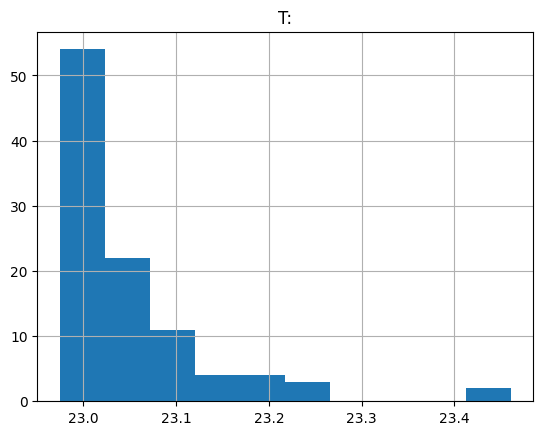

In [6]:
T_samples.hist()

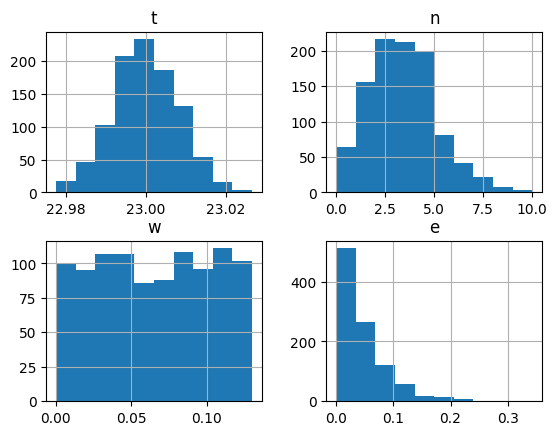

In [7]:
_target = pd.DataFrame(np.stack([sampler._sample_true_prior() for _ in range(1000)]), columns=list("tnwe"))
_target.hist()
pass

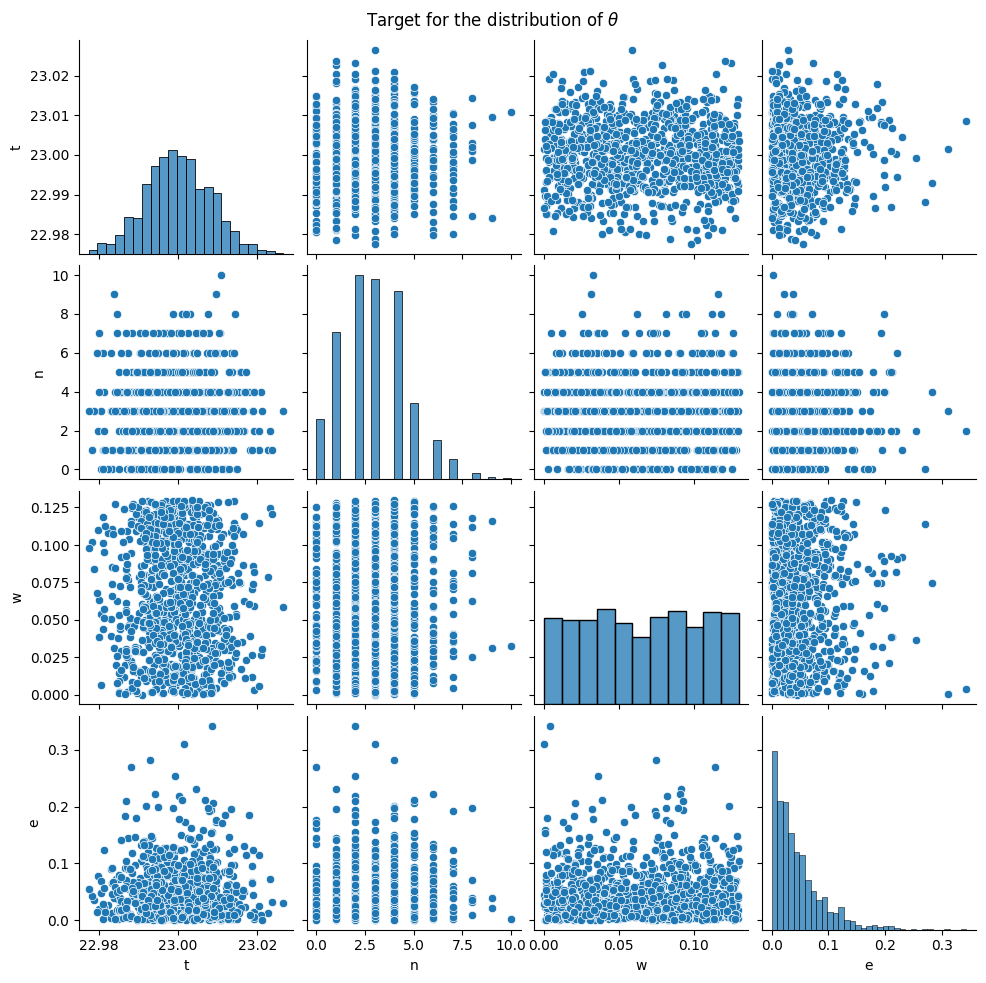

In [8]:
pp = sns.pairplot(_target)
pp.fig.subplots_adjust(top=.95)
pp.fig.suptitle(r"Target for the distribution of $\theta$")
pass

## Exercise 1

The first technique considered is a naive independant sampler.
At each time step, the Markov chain will be sampled from a fixed distribution $g$, and accepted with a set probability or rejected.
This is the basic idea of what are called *Acceptance-Rejection* methods.

The probability of acceptance writes as follows (justification of this choice of $\alpha$ right after):
$$
\alpha(\theta_{proposal}|\theta_{i-1}):=\min\left\lbrace\frac{g(\theta_{i-1}|\theta_{proposal})p(\theta_{proposal})}{g(\theta_{proposal}|\theta_{i-1})p(\theta_{i-1})}, 1\right\rbrace
$$

This brings the foundation of the so-called "Metropolis-Hastings" methods for MCMC: they use this acceptance-rejection method to determine where to move and where to avoid, prefering locations at which the posterior $p$ augments.
Since $p$ is in a ratio, it does not matter that we only know it up to a multiplicative constant (see the proportionality condition above, coming from bayes rule).

The transition probability is then the product of the proposition probability, and the acceptance probability (the chain moves to $\theta_{proposal}$ iff it is proposed by $g$ and then accepted by $\alpha$):
$$
q(\theta_{proposal}|\theta_{i-1}) = g(\theta_{proposal}|\theta_{i-1})\alpha(\theta_{proposal}|\theta_{i-1})
$$
One then verifies that the detailed balance condition is fulfilled for this choice of $q$ since either $g(\theta_{i-1}|\theta_{proposal})p(\theta_{proposal})<g(\theta_{proposal}|\theta_{i-1})p(\theta_{i-1})$ or the oposite:
$$
\frac{q(\theta_{proposal}|\theta_{i-1})p(\theta_{i-1})}{q(\theta_{i-1}|\theta_{proposal})p(\theta_{proposal})} = 1
$$

**Prove the above equality.**

---

*Type your answer here*

---

You will implement this numerical method as a class, inheriting the `Mcmc` parent class.


**Read the code of this class, and implement an `IndSampler` class inheriting from `Mcmc` that uses a gaussian distribution as its proposal kernel $g=\mathcal{N}(\mu, \sigma)$.**
**Run it for 1000 steps.**
**Try multiple choices of $(\mu, \sigma)$ and comment your results.**

In [9]:
## write your code here

## Exercise 2

The last algorithm is too naive, as it tries to propose candidates in a gaussian distribution.
One may find better to perform what is called a *random walk*: coming from a given state, go to the next one by performing a gaussian step from where you stand.

This writes:
$$
\mathbb{Q}_{\theta_{i-1}}:=\mathcal{N}(\theta_{i-1}, \sigma)
$$
So the process is a walk with (independant) random steps $\xi\sim\mathcal{N}(\vec{0}, \sigma)$:
$$
\theta_{proposal} := \theta_{i-1} + \xi
$$
This method is a special case of Metropolis-Hastings, and is called the Metropolis algorithm.

**Use the above expression to write the new $\alpha$ proposal's density. What is the property of the chosen $\mathbb{Q}$ that helps us simplify the expression of $\alpha$?**

---

*Type your answer here*

---

Once again you will implement this numerical method as a child class of `Mcmc`.

**Implement the Metropolis algorithm in a class called `MetropolisSampler`, performing 1000 steps. Compare your results to the independant sampling.**

In [10]:
## write your code here

## Exercise 3

The Gibbs sampler is a "lazy" version of Metropolis-Hastings: instead of updating the whole $\theta_i$ vector at each step, one may propose to walk only in one coordinate direction at a time, conditioned on all the other coordinates.
So one coordinate at a time, they would sample the parameter **according to the *a-priori* distribution** conditionned on the other parameters.

In the case of our toy example, this is especialy easy since we designed the parameters to be independant from each others so $g(\theta_{proposal}[i]|\theta_{i-1}[1\dots i-1, i+1\dots n]):=\tilde{\mathbb{P}}(\theta_{proposal}[i])$.

**Use the `.distribs` attribute of `sampler` to implement a Gibbs sampler called `GibbsSampler`, child of `Mcmc`. In one "step", let it update one coordinate, and let it perform 1000 such steps.**

In [11]:
## write your code here

## Exercise 4

The Metropolis algorithm is a very good quality algorithm, but one may think to themselves that we may help it artificially by "encouraging" it to travel towards more "likely" regions of the parameter-space.

An idea came from *Stochastic Calculus*, and *Stochastic Differential Equations*, to drive the samples closer to the maximum of the target distribution with the help of some "gradient step".

The stochastic equation from which it is inspired is the following "*Langevin diffusion*" equation:
$$
\dot{\theta}=\frac{1}{2}\nabla\ln p(\theta)+\dot{W}
$$
Where $W$ is a brownian motion, and $\nabla$ denotes the gradient.
Note that if $\mathbb{P}$ is known only up to a multiplicative constant, the $(\nabla\ln)$ operator will erase it, which is exactly why there is a logarithm in the equation.

This equation is solved by a time discretization (constant-step $h:=\varepsilon^2$) and a Euler-Maruyama scheme (a variation for SDEs of the Euler scheme):
$$
\theta_i=\theta_{i-1}+\frac{\varepsilon^2}{2}\nabla\ln p(\theta_{i-1})+\varepsilon\xi
$$
with $\xi$ some gaussian noise.

This yields a small modification of the Metropolis algorithm $\theta_i=\theta_{i-1}+\varepsilon\xi$ by adding a step in the upward direction of the distrirbution $\frac{\varepsilon^2}{2}\nabla\ln p(\theta_{i-1})$, but still using the acceptance-rejection method to ensure the detailed-balance.

In our case:
$$
\ln p(\theta_{i-1})=\ln P(T|\theta_{i-1})+\ln P(\theta_{i-1})=-\sum_k \frac{10^{4}}{2}(\hat{T}_k(\theta_{i-1})-T_k)^2-\frac{(t-23)^2}{2\sigma^2}-\frac{(10000\lambda-n)^2}{200\sqrt{(1-\lambda)\lambda}}-\ln(p)-\kappa\epsilon+C
$$
with $C$ a constant independant of the parameters $t, n, w, \epsilon$.

**Compute the gradient of the above expression (i.e. its partial derivatives with respect to the parameters).**

---

*Type your answer here*

---

**Implement the `Mala` class, child of `Mcmc`, from the expression of the gradient you have written above.**

In [12]:
## write your code here